In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error 
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   JAMB_Score                    5000 non-null   int64  
 1   Study_Hours_Per_Week          5000 non-null   int64  
 2   Attendance_Rate               5000 non-null   int64  
 3   Teacher_Quality               5000 non-null   int64  
 4   Distance_To_School            5000 non-null   float64
 5   School_Type                   5000 non-null   object 
 6   School_Location               5000 non-null   object 
 7   Extra_Tutorials               5000 non-null   object 
 8   Access_To_Learning_Materials  5000 non-null   object 
 9   Parent_Involvement            5000 non-null   object 
 10  IT_Knowledge                  5000 non-null   object 
 11  Student_ID                    5000 non-null   int64  
 12  Age                           5000 non-null   int64  
 13  Gen

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
df.columns

Index(['jamb_score', 'study_hours_per_week', 'attendance_rate',
       'teacher_quality', 'distance_to_school', 'school_type',
       'school_location', 'extra_tutorials', 'access_to_learning_materials',
       'parent_involvement', 'it_knowledge', 'student_id', 'age', 'gender',
       'socioeconomic_status', 'parent_education_level',
       'assignments_completed'],
      dtype='object')

## Preparation:
- Remove the student_id column.
- Fill missing values with zeros.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [6]:
df = df.drop('student_id', axis=1)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True) 

y_train = df_train.jamb_score
y_val = df_val.jamb_score
y_test = df_test.jamb_score

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

## Question 1. Most important feature

In [7]:
dtr_q1 = DecisionTreeRegressor(max_depth=1)
dtr_q1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [8]:
print(export_text(dtr_q1, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2. Random forest RMSE

In [9]:
rfr_q2 = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

# validation dataset 
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

rfr_q2.fit(X_train, y_train)
y_pred_q2 = rfr_q2.predict(X_val)
rmse_q2 = root_mean_squared_error(y_val, y_pred_q2)
print('Random forest RMSE : ', rmse_q2)

Random forest RMSE :  42.13724207871227


## Question 3. Number of estimators

In [10]:
s_q3 = np.arange(10, 210, 10)
rmse_q3 = []

for i in s_q3:
    rfr_q3 = RandomForestRegressor(n_estimators=i, random_state=1)
    rfr_q3.fit(X_train, y_train)
    y_pred_q3 = rfr_q3.predict(X_val) 
    rmse = root_mean_squared_error(y_val, y_pred_q3)
    rmse_q3.append(rmse)
                   
df_q3 = pd.DataFrame(s_q3, rmse_q3)#, columns=['n_estimators', 'rmse'])
df_q3

,0
42.137242,10
41.461215,20
41.106171,30
40.917194,40
40.852279,50
40.784281,60
40.677098,70
40.539333,80
40.504346,90
40.516805,100


In [11]:
df_q3.reset_index(drop=False).rename(columns={'index' : 'rmse', 0 : 'n_estimators'})

,rmse,n_estimators
0,42.137242,10
1,41.461215,20
2,41.106171,30
3,40.917194,40
4,40.852279,50
5,40.784281,60
6,40.677098,70
7,40.539333,80
8,40.504346,90
9,40.516805,100


## Question 4. Best max_depth

In [ ]:
max_depth = [10, 15, 20, 25]
s_q4 = np.arange(10, 210, 10)
rmse_q4 = []

for depth in max_depth:
    for estim in s_q4:
        rfr_q4 = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=1)
        rfr_q4.fit(X_train, y_train)
        y_pred_q4 = rfr_q4.predict(X_val) 
        rmse = root_mean_squared_error(y_val, y_pred_q4)
        rmse_q4.append(rmse)

df_q4 = pd.DataFrame([(depth, estim) for depth in max_depth for estim in s_q4], columns=['max_depth', 'n_estimators'])
df_q4['rmse'] = rmse_q4 
result_q4 = df_q4.groupby('max_depth', as_index='False')['rmse'].mean()


max_depth
10    40.392498
15    40.735282
20    40.739734
25    40.787866
Name: rmse, dtype: float64

In [15]:
result_q4.reset_index().sort_values(by='rmse')

,max_depth,rmse
0,10,40.392498
1,15,40.735282
2,20,40.739734
3,25,40.787866


## Question 5. Most important feature

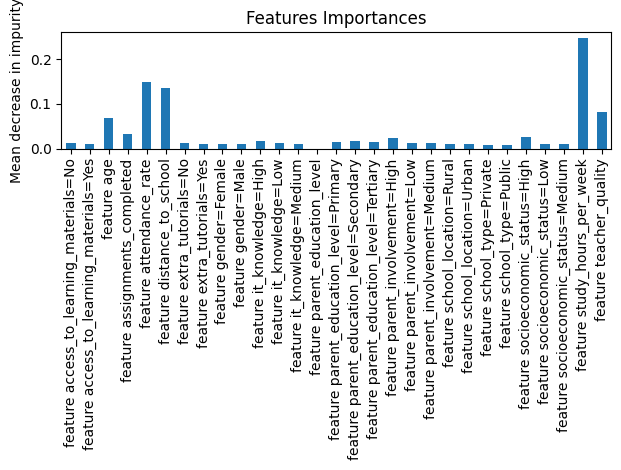

In [31]:
rfr_q5 = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
rfr_q5.fit(X_train, y_train)
importances_q5 = rfr_q5.feature_importances_
feature_names = [f"feature {i}" for i in dv.feature_names_]
q5_importances = pd.Series(importances_q5, index=feature_names)

# plot the importances 
fig, ax = plt.subplots()
q5_importances.plot.bar(ax=ax)
ax.set_title('Features Importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout() 


## Question 6. Eta for XGBoost 

In [32]:
import xgboost as xgb

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [33]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_q6 = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [34]:
y_pred6a = model_q6.predict(dval)
root_mean_squared_error(y_val, y_pred6a)

np.float64(40.43928981689318)

In [36]:
xgb_paramsb = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_q6b = xgb.train(xgb_paramsb, dtrain, num_boost_round=10)

In [37]:
y_pred6b = model_q6.predict(dval)
root_mean_squared_error(y_val, y_pred6b)

np.float64(40.43928981689318)